# Introducción

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con los clientes basada en datos analíticos para combatir uno de los problemas más críticos en la industria del fitness: la pérdida silenciosa de clientes.

¿Cómo se puede distinguir entre un cliente en vacaciones y uno que ha perdido interés? La respuesta está en los datos: patrones de asistencia, duración de contratos, interacción con servicios adicionales y características demográficas.

Lo que realizaremos:
Predecir el riesgo de abandono en el próximo mes.

Segmentar a los usuarios en grupos con comportamientos y necesidades distintivas.

Priorizar acciones basadas en los factores que más impulsan la rotación.

No solo se busca encontrar el problema, sino la creación de estrategias concretas.

Exploraremos cómo los datos revelan quiénes se van, por qué lo hacen y qué puede hacer Model Fitness para convertirse en un referente en retención inteligente.

## Importar librerias, descargar datos.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
gym = pd.read_csv('/datasets/gym_churn_us.csv')

In [3]:
print(gym.info())
print(gym.head())
print(gym.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

## Llevar a cabo el análisis exploratorio de datos (EDA)

In [4]:
gym.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [5]:
# Agrupamos la columna 'Churn' y calculamos la media de cada característica
churn_grouped = gym.groupby('Churn').mean()
print(churn_grouped)

         gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                                     
0                               2.0

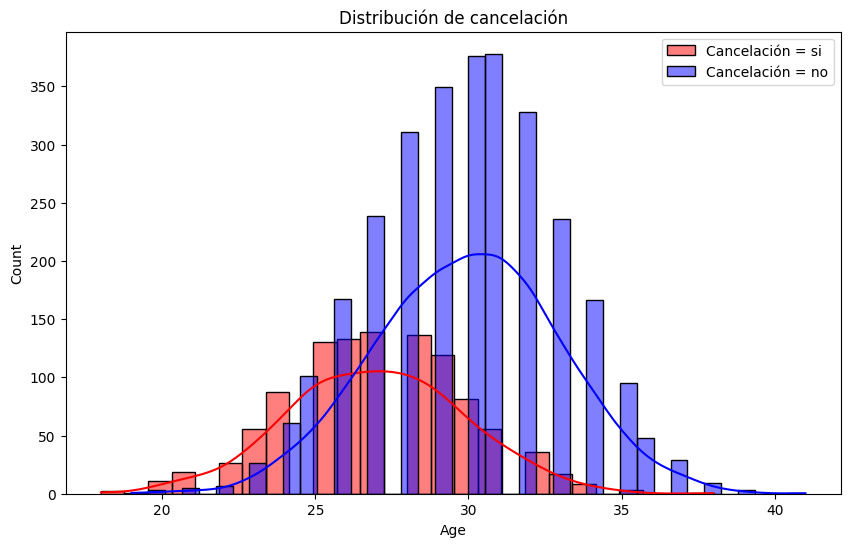

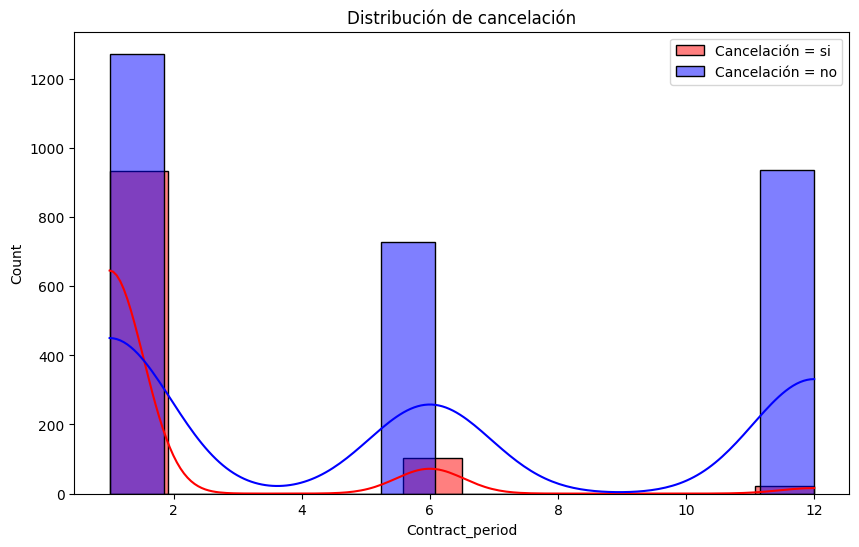

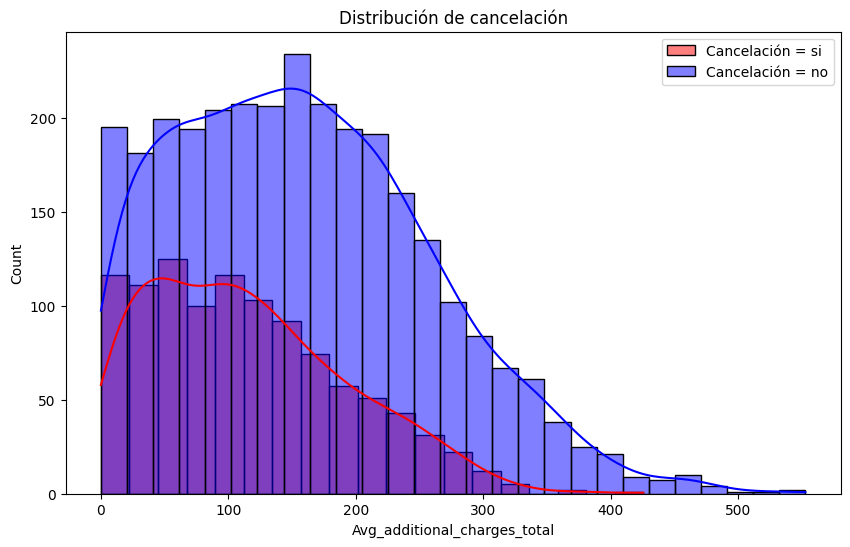

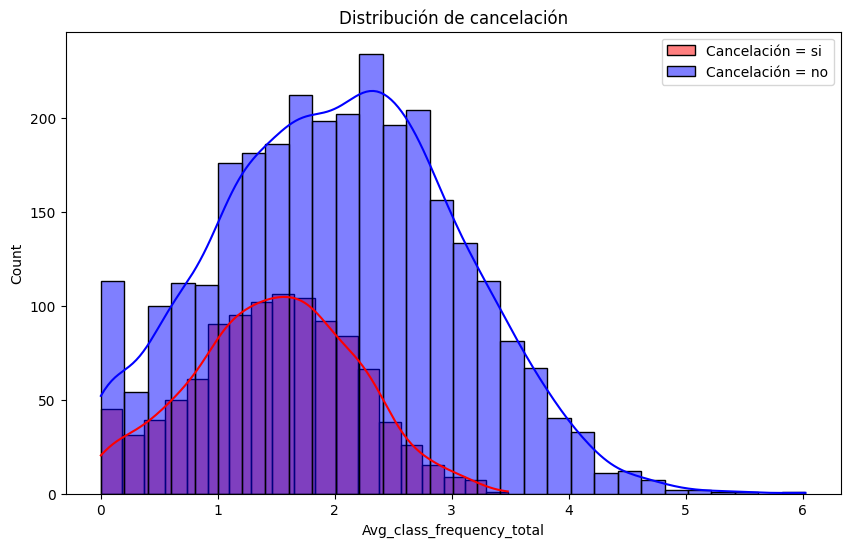

In [6]:
# Separamos los datos en dos grupos:
churn_yes = gym[gym['Churn'] == 1]
churn_no = gym[gym['Churn'] == 0]

# Trazamos histogramas para algunas características
features = ['Age', 'Contract_period', 'Avg_additional_charges_total', 'Avg_class_frequency_total']

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(churn_yes[feature], color='red', label='Cancelación = si', kde=True)
    sns.histplot(churn_no[feature], color='blue', label='Cancelación = no', kde=True)
    plt.title(f'Distribución de cancelación')
    plt.legend()
    plt.show()

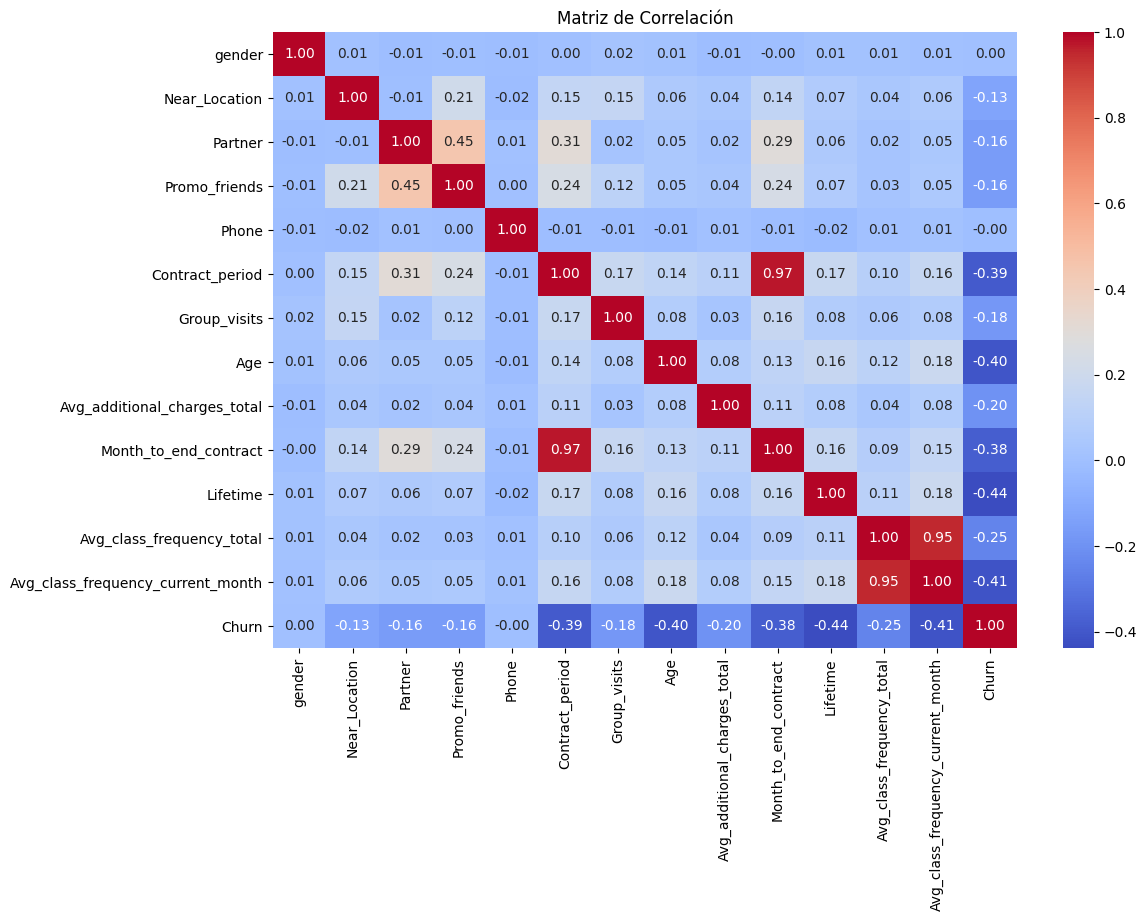

In [7]:
# Calculamos la matriz de correlación
gym_corr = gym.corr()

# Mostramos la matriz de correlación con un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(gym_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

## Construir un modelo para predecir la cancelación de usuarios

In [8]:
# Separamos características y variable objetivo
X = gym.drop('Churn', axis=1)  
y = gym['Churn'] 

# Dividimos los datos en conjuntos de entrenamiento y validación (80% entrenamiento, 20% validación)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Regresión Logística y entrenamos el modelo
logistic_model = LogisticRegression(random_state=0, max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predecimos en el conjunto de validación
y_pred_logistic = logistic_model.predict(X_test)

# Evaluamos el modelo de regresión logística
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)

print("Resultados de Regresión Logística:")
print(f"Exactitud (Accuracy): {accuracy_logistic:.2f}")
print(f"Precisión (Precision): {precision_logistic:.2f}")
print(f"Recall: {recall_logistic:.2f}")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_logistic))
print("\n")

Resultados de Regresión Logística:
Exactitud (Accuracy): 0.92
Precisión (Precision): 0.86
Recall: 0.83
Matriz de Confusión:
[[575  27]
 [ 34 164]]




In [9]:
#Realizamos Random Forest
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)  

# Predecimos en el conjunto de validación
y_pred_rf = rf_model.predict(X_test)

# Evaluamos el modelo de bosque aleatorio
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print("Resultados de Bosque Aleatorio:")
print(f"Exactitud (Accuracy): {accuracy_rf:.2f}")
print(f"Precisión (Precision): {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rf))
print("\n")

# Comparación de los modelos
print("Comparación de Modelos:")
print(f"Exactitud: Regresión Logística = {accuracy_logistic:.2f}, Bosque Aleatorio = {accuracy_rf:.2f}")
print(f"Precisión: Regresión Logística = {precision_logistic:.2f}, Bosque Aleatorio = {precision_rf:.2f}")
print(f"Recall: Regresión Logística = {recall_logistic:.2f}, Bosque Aleatorio = {recall_rf:.2f}")

Resultados de Bosque Aleatorio:
Exactitud (Accuracy): 0.92
Precisión (Precision): 0.84
Recall: 0.82
Matriz de Confusión:
[[571  31]
 [ 36 162]]


Comparación de Modelos:
Exactitud: Regresión Logística = 0.92, Bosque Aleatorio = 0.92
Precisión: Regresión Logística = 0.86, Bosque Aleatorio = 0.84
Recall: Regresión Logística = 0.83, Bosque Aleatorio = 0.82


La Regresión Logística obtuvo resultados ligeramente mejores que el Bosque Aleatorio, aunque ambos modelos son muy competitivos.

La Regresión Logística es la mejor opción para Model Fitness, ya que es más eficiente en métricas clave para el negocio. Suele ser más interpretable, lo que ayuda a entender qué variables influyen en la cancelación. 
La diferencia es relevante en contextos con alto costo de falsos negativos.

##  Crear clústeres de usuarios

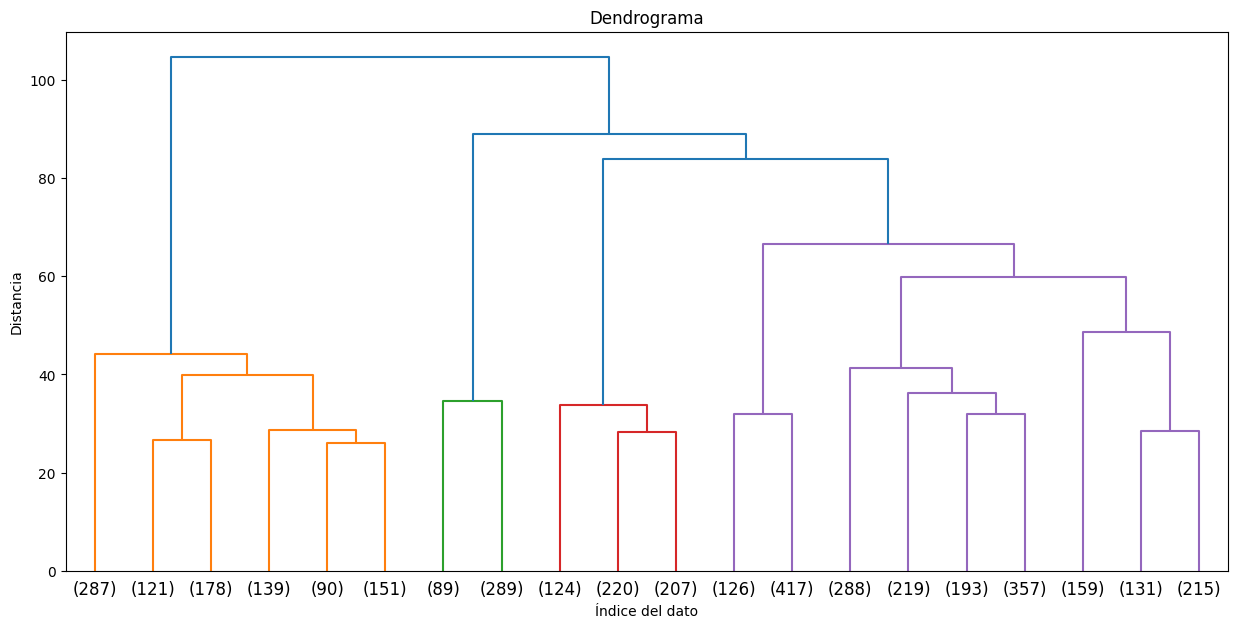

In [10]:
# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Matriz de distancias y dendrograma
plt.figure(figsize=(15, 7))
linked = linkage(X_scaled, method = 'ward')

dendrogram(linked, truncate_mode='lastp', p=20)  # Mostramos últimos 20 clusters para evitar saturación
plt.title('Dendrograma')
plt.xlabel('Índice del dato')
plt.ylabel('Distancia')
plt.show()

In [11]:
# Clustering con K-means
kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(X_scaled)

# Valores medios de las características para los clústeres
gym['cluster'] = labels
mean_values = gym.groupby(['cluster']).mean()

print(mean_values)

           gender  Near_Location   Partner  Promo_friends     Phone  \
cluster                                                               
0        0.502970       0.959406  0.783168       0.574257  1.000000   
1        0.522078       0.862338  0.470130       0.306494  0.000000   
2        0.495050       0.000000  0.463366       0.079208  1.000000   
3        0.485737       1.000000  0.350238       0.240095  1.000000   
4        0.559666       0.976134  0.356802       0.230310  0.998807   

         Contract_period  Group_visits        Age  \
cluster                                             
0              10.889109      0.542574  29.982178   
1               4.787013      0.425974  29.301299   
2               2.352475      0.215842  28.477228   
3               1.948494      0.341521  28.167987   
4               2.669451      0.473747  30.125298   

         Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster                                                 

**Alta cancelación en Clústeres 2 y 3**

**Clúster 3:** 51.4% de cancelación.

Contratos muy cortos (1.9 meses en promedio).

Baja participación en clases grupales (0.34 vs. 0.54 en clústeres leales).

Menor gasto en servicios adicionales.

**Clúster 2:** 44.4% de cancelación.

Todos están lejos del gimnasio (Near_Location = 0).

Frecuencia de clases baja (1.47 vs. 2.85 en clúster 4).

**Clúster 4:** Alto Potencial de Retención
Cancelación(6.8%) a pesar de contratos cortos (2.7 meses).

Alta frecuencia de clases (mayor de todos: 2.85 clases/semana).

Proximidad al gimnasio (Near_Location = 0.97).

**Cluster 0** = Lealtad Garantizada
Cancelación casi nula (2.7%) y contratos largos (10.9 meses).

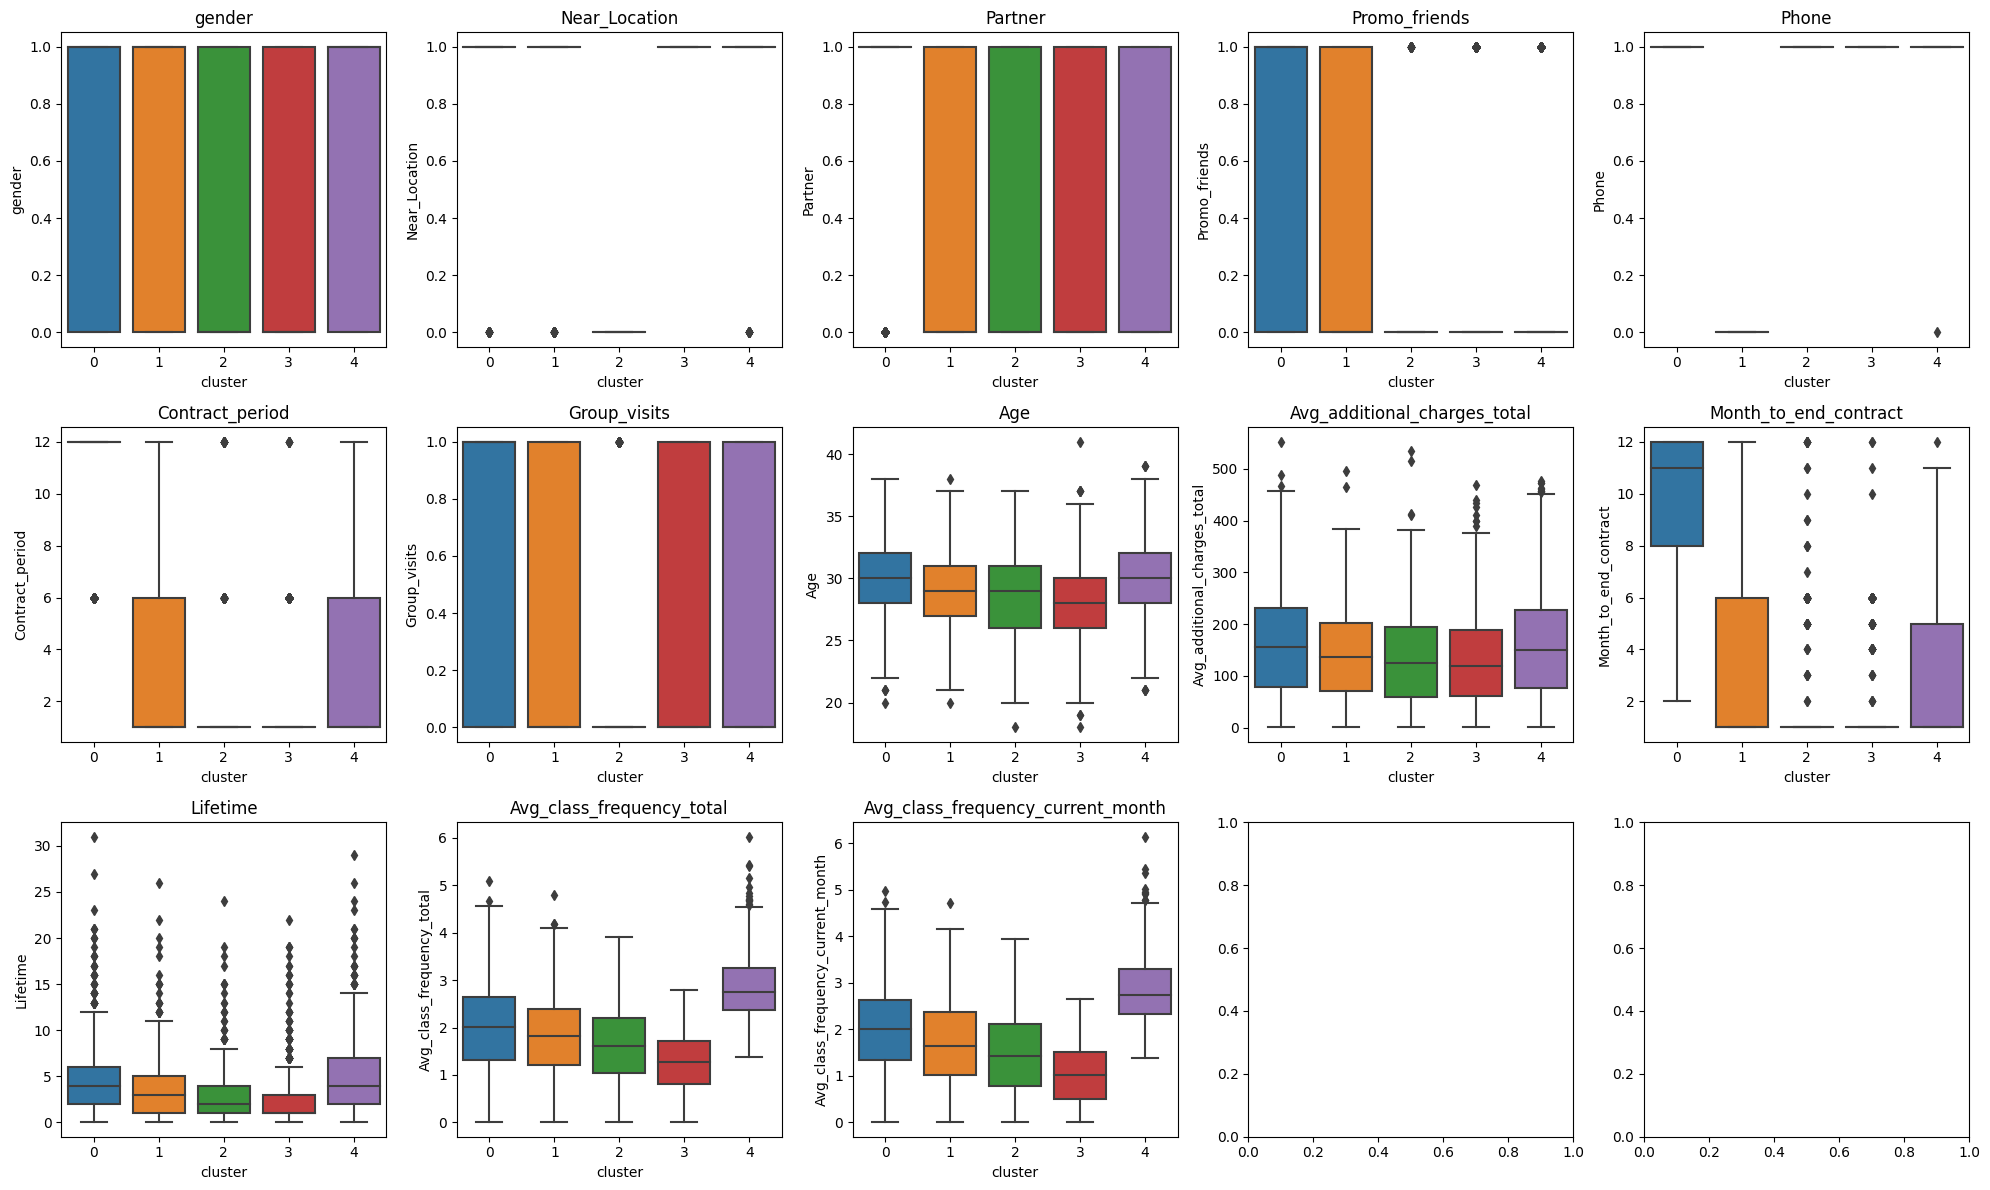


Tasa de cancelación por cluster (%):
 cluster
0     2.772277
1    26.753247
2    44.356436
3    51.426307
4     6.801909
Name: Churn, dtype: float64


In [12]:
# Distribuciones por cluster
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.ravel()

for i, col in enumerate(X.columns):
    sns.boxplot(x='cluster', y=col, data=gym, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

# Tasa de cancelación por cluster
churn_rate = gym.groupby('cluster')['Churn'].mean() * 100
print("\nTasa de cancelación por cluster (%):\n", churn_rate)

**Clústeres de Alto Riesgo a irse**

Clúster 3: 51.4% de cancelación

Clúster 2: 44.4% de cancelación

**Clúster de Riesgo Moderado**

Clúster 1: 26.8% de cancelación

**Clústeres Leales**

Clúster 0: 2.8% de cancelación

Clúster 4: 6.8% de cancelación

# Conclusión y posibles soluciones

Factores clave y estrategias integradas para reducir la taza de cancelación:

Contratos cortos + baja frecuencia de visitas son la combinación más riesgosa.

**Se puede prioritizar la siguiente solución:** contratos largos (ejemplo: 12 meses con 1 mes gratis ofrecer hasta 4) y crear programas de engagement basados en metas (ejemplo: "20 clases/mes = descuento en renovación").

**Para los clientes nuevos:** Se puede dar un mes de coaching personalizado para evitar el abandono temprano y agarren un gusto por el gimnasio.

**Para los clientes con mas tiempo pero con baja actividad:** se puede fomentar una comunidad y que inviten a un amigo ciertos días, tambien descuentos exclusivos por lealtad.

Utilización de modelos predictivos para identificar clientes en riesgo y activar ofertas justo a tiempo (ejemplo: "Renueva hoy y llévate 1 masaje").

**No ignoremos los servicios adicionales:** ofrécer bonos de lealtad (ejemplo: "Por 6 meses de renovación, 1 consulta de nutriologo gratis").

**Los clientes del clúster 4** son embajadores potenciales. Se puede crear un programa de referidos con recompensas (ejemplo: "Trae un amigo: tú ganas 1 semana gratis, él obtiene 20% de descuento").

Combinar intervenciones tempranas con estrategias de lealtad, usando los datos para personalizar incentivos. La clave está en actuar antes de que el cliente decida irse.